# Analysis
_IMDB Moview Review Sentiment Analysis_  


### Goal

With the data cleaning completed, we are now ready to begin the analysis

Our goal in this project is to create the best model to predict the _polarity_ of movie reviews.

>**Polarity**: whether the expressed opinion in a document, a sentence or an entity feature/aspect is positive, negative, or neutral.
[Source](https://en.wikipedia.org/wiki/Sentiment_analysis)

In our case, we will create binary classification models predicting wheter a given review is _positive_ or _negative_.

###  Plan of the analysis
#### 1. Setup and EDA

We will first import the dataset and do some rudimentary EDA as the data is very simple and consists of two columns: the review and the associated sentiment.

#### 2. Analysis

We have selected three classification methods for our analysis:

* Decision Tree
* K-Nearest Neighbors
* Logistic Regression

We will fine-tune each of them to try and get the highest predictive accuracy. We will then compare the methods and analyse their results

#### 3. Conclusion

We will then compare the accuracy of the three models and see which performed best.

## 1. Setup and EDA

First let's import all the libraries necessary to our analysis.

_Note: The data cleaning notebook_ ```1_data_cleaning.ipynb``` _should be run first as it installs the dependencies_

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import classification_report

sp = spacy.load('en_core_web_sm')

%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("notebook")

plt.rcParams['figure.figsize'] = [10, 7]

### Import the cleaned dataset
The dataset we are working with here is the output of our cleaning step.

In [2]:
data = pd.read_csv("../data/extremely_clean_dataset.csv") 
data.head()

,review,sentiment
0,reviewer mention watch episode hook right exac...,positive
1,wonderful little production technique very una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy think zombie close...,negative
4,petter love time money visually stunning film ...,positive


### EDA
The dataset is composed of 50'000 reviews (25'000 of positive ones and the same number of negative ones).

In [3]:
data.describe()

,review,sentiment
count,50000,50000
unique,49569,2
top,love variety not solely cook great very captiv...,negative
freq,5,25000


In [4]:
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [5]:
base_rate = max(data['sentiment'].value_counts()) / data.shape[0]
print("Base rate: {}".format(base_rate))

Base rate: 0.5


As a result, the base rate for this dataset is 0.5, which our models will have to beat.

## 2. Analysis

#### Split observations in train / test set
We set the train and test set after having applied the bag of words model to the reviews using CountVectorizer. CountVectorizer simply counts how many times a token (in our example it will be a word or a pair of words) appears in a review.

In [3]:
# Bag of words representation using CountVectorizer
count_vector = CountVectorizer(ngram_range = (1,2))

X = count_vector.fit_transform(data['review'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

#### Helper functions

In [4]:
def confusion_matrix(classifier, X_test, y_test):
    sns.set_style("white")
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
        disp.ax_.set_title(title)
    
    sns.set_style("darkgrid")

###  2.1 K-Nearest-Neighbour Classification (KNN)

Based on the content of the reviews, the KNN method assigns to every observation of the test set k observations from the training set, that are located the closest to them in the mutidimensionnal space. The euclidian distance is used as a measure of proximity. Once those "nearest neighbours" have been identified, the KNN method proceeds to a vote, where every nearest neighbour votes for his own category (in our case : positive / negative). The observations of the test set then inherit the category of the majority. 

#### Tuning the value of k
Since k is defined as the number of nearest neighbours taken in account for this method, we can play with this parameter. If we plot the accuracy against k (we used the letter N instead of k in our example), we expect the accuracy at first to rise for increasing values of k, until it reaches a maximum and then decreases. 

The initial rise is due to the fact that more voters are taken into account and according to the concept of "wisdom of the crowds", this is likely to lead to a higher accuracy. But at some point, when the value for k is high, adding more neighbors to the vote will decrease the accuracy, since the newly added neighbors are so far away from the test observation that they don't have any similarity with the test observation anymore.

We started by defining an arbitrary range for the values of k: 1 to 71


Text(0.5, 0, 'N')

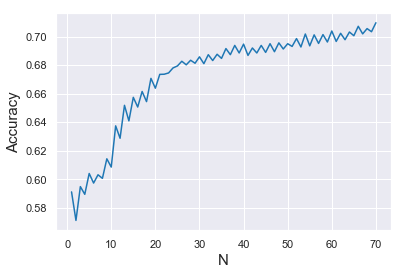

In [9]:
scores = {}
for n in range(1, 71):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores[n] = knn.score(X_test, y_test)

plt.plot([key for key in scores.keys()], [value for value in scores.values()])
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('N', fontsize=15)

After what we've discussed above, it is obvious that this graph doesn't correspond to our expectations, since the accuracy only keeps increasing with growing values of k and never decreases. That's why we decided to move the considered range for the k-values upwards and plot the same graph again. 

Text(0.5, 0, 'N')

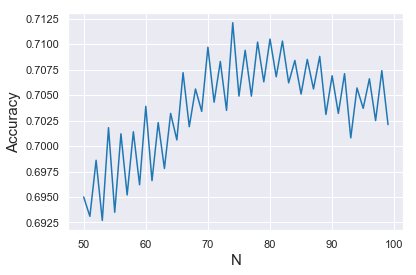

In [9]:
scores = {}
for n in range(50, 100):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores[n] = knn.score(X_test, y_test)

plt.plot([key for key in scores.keys()], [value for value in scores.values()])
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('N', fontsize=15)

Now this result is satisfying, since we clearly have a maximum here. We will extract the value for k that maximizes the accuracy.

In [10]:
best_n = max(scores, key=scores.get)
print("Number of neighbours giving the highest accuracy: {}, Accuracy: {}".format(best_n, scores[best_n]))

Number of neighbours giving the highest accuracy: 74, Accuracy: 0.7121


#### Complete KNN model

We will use uniform weights as distance gives us similar or lower results.

In [5]:
knn = KNeighborsClassifier(n_neighbors=best_n)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=74, p=2,
                     weights='uniform')

In [7]:
knn.score(X_test, y_test)

0.7055

##### Classification report

In [8]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

    negative       0.74      0.63      0.68      4996
    positive       0.68      0.78      0.73      5004

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000



##### Confusion matrix

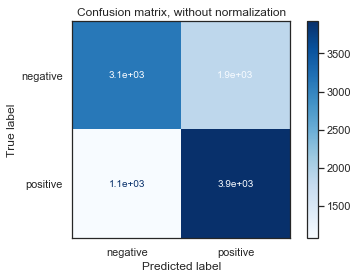

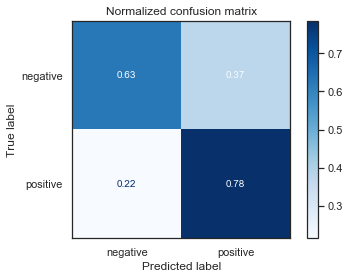

In [11]:
confusion_matrix(knn, X_test, y_test)

### 2.2 Decision Trees

The next method we will try is decision tree.

#### Tuning the depth of the tree

Here again we can play with an important parameter from the model: the depth. As seen in the course, increasing depth initially increases the accuracy. This happens until we overfit the model and the accuracy starts dropping down.

We use the same methodology as for the KNN method: define an arbitrary range of values (1 to 21) for the depth and then plot it against the corresponding accuracy. 

Text(0.5, 0, 'Depth')

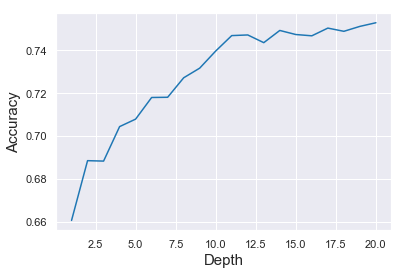

In [15]:
scores = {}
for d in range(1, 21):
    tree = DecisionTreeClassifier(max_depth=d)
    tree.fit(X_train, y_train)
    scores[d] = tree.score(X_test, y_test)
    
plt.plot([key for key in scores.keys()], [value for value in scores.values()])
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Depth', fontsize=15)

As we can see, the highest accuracy is obtained with the upper-bound value from our range of depth values. This indicates that it is quite likely that the accuracy-maximizing depth <strong>isn't</strong> included in our range. 

In [16]:
best_d = max(scores, key=scores.get)
print("Max depth giving the highest accuracy: {}, Accuracy: {}".format(best_d, scores[best_d]))

Max depth giving the highest accuracy: 20, Accuracy: 0.7529


With a depth of 20, we obtain an accuracy of 75%. We assume that this number will increase with a deeper tree, but due to the long computation time of the Decision Tree algorithm we won't try higher depths.

#### Complete Decision Tree model

In [37]:
tree = DecisionTreeClassifier(max_depth=best_d)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [38]:
tree.score(X_test,y_test)

0.7451

_Note: graphviz must be installed and in the PATH for this step_

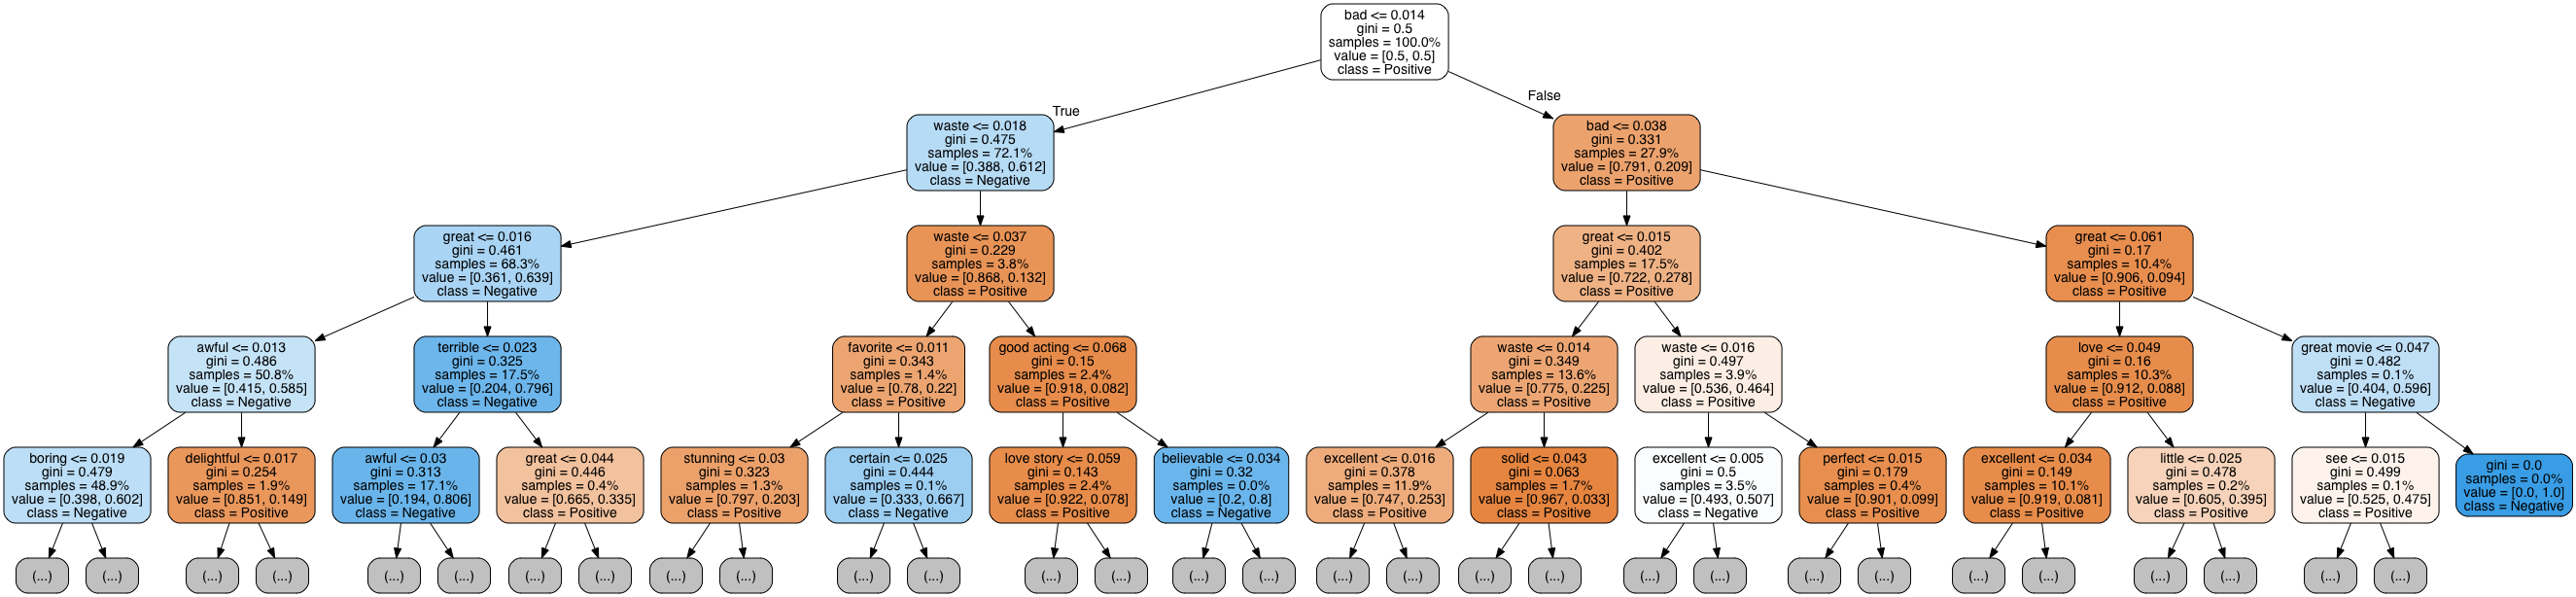

In [39]:
from graphviz import Source

graph = Source(export_graphviz(tree, max_depth = 4, feature_names=count_vector.get_feature_names(), class_names = ['Positive', 'Negative'], proportion=True, filled=True, rounded=True))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

##### Classification report

In [40]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

    negative       0.77      0.71      0.73      4996
    positive       0.73      0.78      0.75      5004

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000



##### Confusion matrix

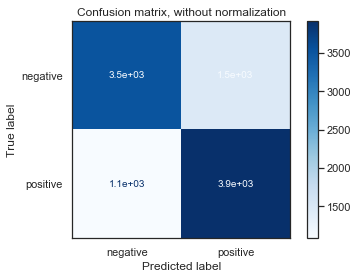

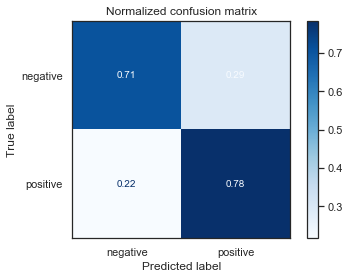

In [41]:
confusion_matrix(tree, X_test, y_test)

### 2.3 Logistic Regression

The last model we tested is the logistic regression, which gave us the best results.

#### Logistic Model with CountVectorizer

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
lr.score(X_test, y_test)

0.8979

#### Logistic Model with Tf-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 2))

X = tfidf_vectorizer.fit_transform(data['review'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
lr.score(X_test, y_test)

0.8843

#### Tuning Logistic Model with CountVectorizer

The logistic model with count vectorizer has been the model with highest accuracy up until now. We tested other models and methods such as SVC, Random Forest and others but they had lower accuracy

As a result, we will fine tune the parameters of the logitstic with count vectorizer using GridSearchCV.

In [26]:
from sklearn.model_selection import GridSearchCV
import numpy as np

pipe = Pipeline([('classifier' , LogisticRegression())])

param_grid = [
    {
        'classifier': [LogisticRegression()],
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__C' : np.logspace(-4, 4, 20),
        'classifier__solver' : ['liblinear']
    },
]

grid_search = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
result = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.8min finished


In [27]:
result.score(X_test, y_test)

0.9008

In [28]:
result.best_params_

{'classifier': LogisticRegression(C=10000.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 10000.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

In [29]:
best_lr = result.best_params_['classifier'].fit(X_train, y_train)

##### Classification report

In [30]:
print(classification_report(y_test, best_lr.predict(X_test)))

              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      4996
    positive       0.89      0.91      0.90      5004

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



##### Confusion matrix

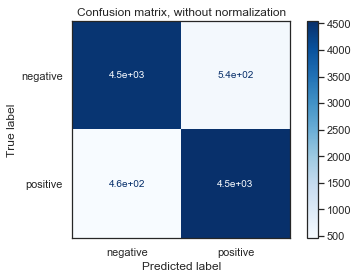

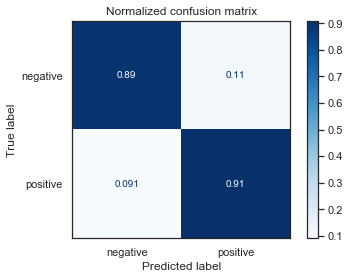

In [31]:
confusion_matrix(best_lr, X_test, y_test)

##### Precision Recall Curve
Logistic regression is a method that assigns to each observation of the test set a probability that it belongs to a certain class. In order to classify the different observations based on their probability, the algorithm needs to be given a threshold that indicates for which probability level an observation will be assigned to a specific class rather than to another.
Sklearn uses by default a 0.5 threshold, but it is possible to try all different threshold options between 0 and 1. Since variatons in the threshold have an impact on accuracy, recall and precision, it is possible to plot all combinations of precision and recall, that arise from different thresholds, in a 2-dimensional graph. This is what is done in a so-called precision-recall curve.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.96')

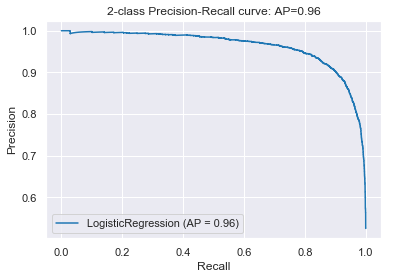

In [32]:
y_score = best_lr.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score, pos_label="positive")

disp = plot_precision_recall_curve(best_lr, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

##### Biggest coefficients
To have an insight in how our model works and if it associates positive/negative words correctly, we represent the words with the highest/lowest coefficients.

In [33]:
def get_interesting_features(features):
    interesting_coefs = []
    for best_positive in sorted(features.items(), key=lambda x: x[1], reverse=True)[:5]:
        interesting_coefs.append(best_positive)

    for best_negative in sorted(features.items(), key=lambda x: x[1])[:5]:
        interesting_coefs.append(best_negative)
    return interesting_coefs

In [34]:
def graph_interesting_features(interesting_features):
    sorted_by_coef = sorted(interesting_features, key=lambda tup: tup[1], reverse=True)

    feature = [elem[0] for elem in sorted_by_coef]
    coef = [elem[1] for elem in sorted_by_coef]

    plt.bar(feature, coef)
    plt.xticks(feature, fontsize=12)
    plt.xticks(rotation=30)
    plt.show()

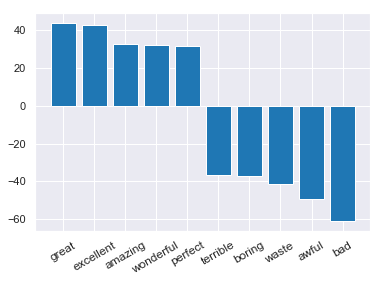

In [35]:
model_features = {
    word: coef for word, coef in zip(
        count_vector.get_feature_names(), best_lr.coef_[0]
    )
}

interesting_features = get_interesting_features(model_features)
graph_interesting_features(interesting_features)

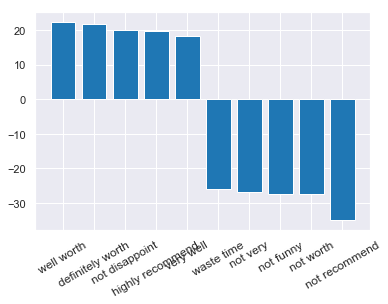

In [36]:
two_gram_features = {key: model_features[key] for key in model_features.keys() if len(key.split(' ')) == 2}
intersting_features = get_interesting_features(two_gram_features)
graph_interesting_features(intersting_features)

It is interesting to see that the top-ten 1-grams all have higher coefficients than the top-ten 2-grams. 

# 3. Conclusion

Summary of the model accuracies:


| Model        | Accuracy           |
| ------------- |-------------:|
| KNN      | 0.7055 | 
| Decision Tree      | 0.7451      | 
| **Logistic Regression** | **0.9008**      | 

As we can see that the best performing method of classification of the reviews into binary class positive/negative is the Logistic Regression method with CountVectorizer. It achieves a score of more than 0.90 and thus beats both the kNN and the decision tree methods.